In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from model.losses import SmoothPinballLoss, PinballLoss
from model.model import LSTM
from data.preprocessing import FrameTorch
from model.trainer import Trainer
from utils import get_scores

torch.manual_seed(0)

#### Import data and set quantiles

In [2]:
PATH_DATA = Path.cwd().parent / 'data' / 'files'

data = pd.read_csv((PATH_DATA / 'data.csv'), index_col='time')

# quantiles to predict
quantiles = torch.tensor([0.025, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 0.975])

# lookback periods
slide = 6

In [3]:
data_non_spread = data.drop(data.filter(regex='spread').columns, axis=1)
# intialize frametorch
frametorch_all = FrameTorch(data_non_spread)
# split data
frametorch_all.split_data()
# scale data
frametorch_all.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch_all.data_to_loader(slide=slide)

In [4]:
# number of inputs and outputs
n_inputs = frametorch_all.data.shape[1] - 1
n_outputs = len(quantiles)

## LSTM USING ALL DATA WITH SMOOTH PINBALL LOSS

In [5]:
# model
quantilenet_smooth = LSTM(input_size=n_inputs, out_size=n_outputs, hidden_size=slide, n_layers=2)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet_smooth.parameters(), lr=0.0003)
# trainer class
trainer_smooth = Trainer(quantilenet_smooth, criterion, optimizer)

#### TRAIN DE MODEL

In [17]:
quantilenet_smooth = trainer_smooth.fit(
    train_loader, val_loader, epochs=2000, n_logger=100, patience=100
)

## LSTM USING ALL DATA WITH PINBALL LOSS

In [7]:
data_non_spread = data.drop(data.filter(regex='spread').columns, axis=1)
# intialize frametorch
frametorch = FrameTorch(data_non_spread)
# split data
frametorch.split_data()
# scale data
frametorch.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch.data_to_loader(slide=slide)

#### MODEL PREPARATION

In [8]:
# number of inputs and outputs
n_inputs = frametorch.data.shape[1] - 1
n_outputs = len(quantiles)

In [9]:
# model
quantilenet = LSTM(input_size=n_inputs, out_size=n_outputs, hidden_size=slide, n_layers=2)
# criterion to use
criterion = PinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet.parameters(), lr=0.0003)
# trainer class
trainer = Trainer(quantilenet, criterion, optimizer)

#### TRAIN DE MODEL

In [18]:
quantilenet = trainer.fit(
    train_loader, val_loader, epochs=2000, n_logger=100, patience=100
)

## COMPARE MODELS

In [19]:
train_loader, val_loader, test_loader = frametorch.data_to_loader(slide=slide)

# validation input and target
inputs, target = val_loader.dataset.inputs, val_loader.dataset.target
y_test = pd.Series(target.squeeze().tolist())

# quantilenet predictions
y_pred_quantilenet = trainer.best_model(inputs)
y_preds_quantilenet = pd.DataFrame(y_pred_quantilenet.tolist())

Predictions without spread

In [20]:
train_loader, val_loader, test_loader = frametorch.data_to_loader(slide=slide)

# validation input and target
inputs, _ = val_loader.dataset.inputs, val_loader.dataset.target

# quantilenet predictions
y_pred_quantilenet_smooth = trainer_smooth.best_model(inputs)
y_preds_quantilenet_smooth = pd.DataFrame(y_pred_quantilenet_smooth.tolist())

### COMPARE MODEL TYPES

Convergence

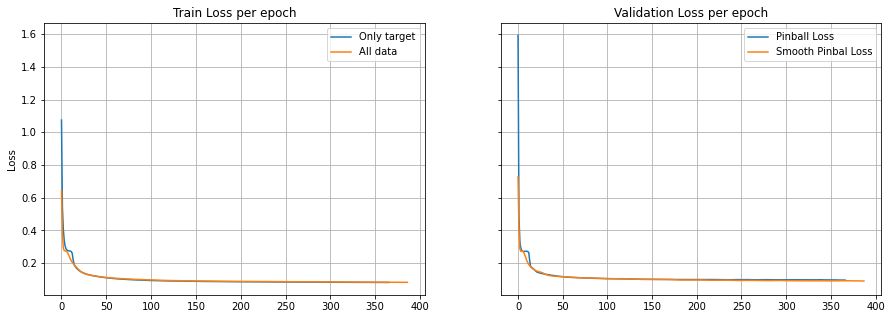

In [16]:
loss_ss = pd.Series(trainer.train_losses[1:])
validations_losses_ss = pd.Series(trainer.val_losses)

loss_ss_smooth = pd.Series(trainer_smooth.train_losses[1:])
validations_losses_ss_smooth = pd.Series(trainer_smooth.val_losses)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

loss_ss.plot(ax=ax[0])
loss_ss_smooth.plot(ax=ax[0])
validations_losses_ss.plot(ax=ax[1])
validations_losses_ss_smooth.plot(ax=ax[1])

ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss per epoch')
ax[0].legend(['Only target', 'All data'])
ax[0].grid()

ax[1].set_title('Validation Loss per epoch')
ax[1].legend(['Pinball Loss', 'Smooth Pinbal Loss'])
ax[1].grid()

Scores

In [21]:
quantilenet_scores = get_scores(y_pred_quantilenet, target, quantiles)
quantilenet_smooth_scores = get_scores(y_pred_quantilenet_smooth, target, quantiles)

final_scores = pd.concat(
    [quantilenet_scores, quantilenet_smooth_scores], axis=1, keys=['Pinball Loss', 'Smooth Pinball Loss']
)
final_scores

,Pinball Loss,Smooth Pinball Loss
QS,0.089476,0.086560
IS,0.311254,0.301852
Sharpnees,0.204039,0.197225
ACE,2.021712,1.548798


Plots